In [32]:
import pickle
from copy import deepcopy

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import numpy as np; np.set_printoptions(suppress=True, linewidth=180)
import pandas as pd; pd.set_option('display.width', 500)
import matplotlib.pyplot as plt

from scipy.optimize import minimize

import os
import ipywidgets as widgets
from ipyfilechooser import FileChooser

from plot_module import plot_ODE, plot_gillespie, plot_simulator_graph, plot_neuron_graph_subset
from sim_param_from_network import names_from_network, gillespie_param_from_network, dataframes_from_network, ODE_from_network, start_state_from_nodes
from neuron_graph_transform import neuron_graph_transform
from neuron_graph_bioparam import add_bioparam_attributes, calculate_influx_efflux ,calculate_target_nss, adjust_soma_birthrate


from simulate import simulate_ode, simulate_gillespie
from graph_flow_solve import solve_subgraph_flux

In [33]:
# Specify the directory
directory = 'neuron_shape_data'
fc = FileChooser(directory)
display(fc)

FileChooser(path='/home/daniel/Projects/2023_Jones_Lab_mtDNA/SSD/SSD_Neuron/neuron_shape_data', filename='', t…

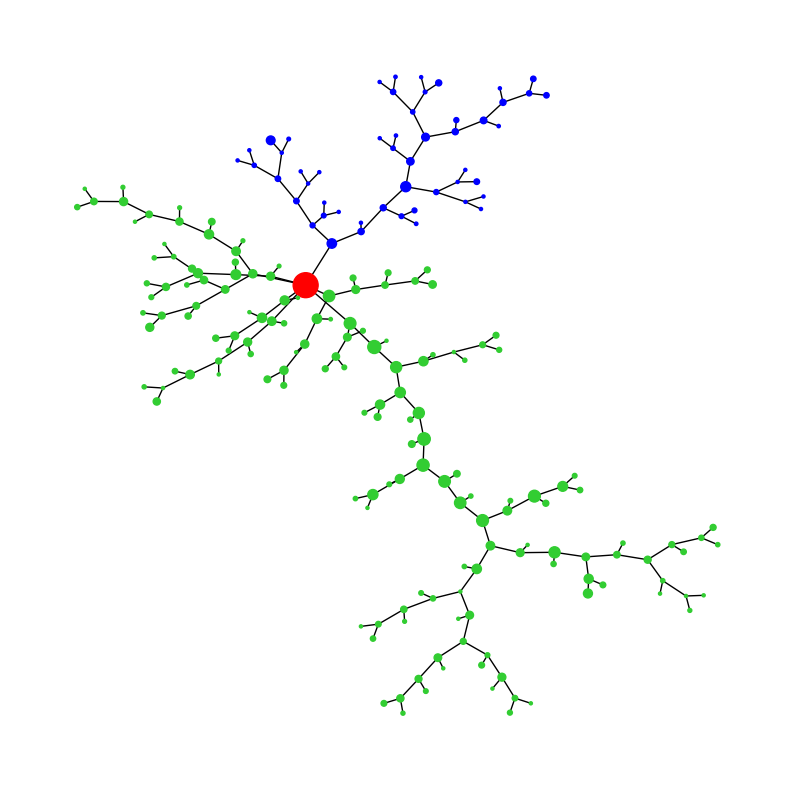

In [53]:
file_path = fc.selected
assert file_path != None, 'No file selected!'
assert os.path.isfile(file_path), f'"{file_path}" does not point to a file!'

file_name = os.path.basename(file_path)
name, extension = os.path.splitext(file_name)
assert extension == '.pkl', f'selected file must be a pickled nxgraph!'


with open(file_path, 'rb') as f:
    imported_neuron_graph = pickle.load(f)    

plot_neuron_graph_subset(imported_neuron_graph)

In [54]:
DELTA = 0.5
DEATH_RATE = 0.4
SWITCH_RATE_AR = 0.01
SWITCH_RATE_RA = 0.01

TRANSP_SPEED = 14000

SOMA_CB = 1.0
SOMA_BR = 3.2
SOMA_NSS = 500
SOMA_DIFFUSION = 0.4
SOMA_MITO_DENSITY = 2 # number of mt/um^3 of volume


AXON_MITO_DENSITY = 2 # number of mt/um^3 of volume
AXON_TRNSP_ANT = 8
AXON_TRNSP_RET = 6

# AXON_TERMINAL_INFLUX = 2*DEATH_RATE*AXON_NODE_POP
# AXON_TERMINAL_EFFLUX = DEATH_RATE*AXON_NODE_POP


DENDRITE_MITO_DENSITY = 2 # number of mt/um^3 of volume

bio_param = {
    # global parameters    
    'delta': DELTA, 
    'switch_rate_ar': SWITCH_RATE_AR,
    'switch_rate_ra': SWITCH_RATE_RA,
    
    # soma parameters
    'soma_death_rate': DEATH_RATE, 
    'soma_mito_density': SOMA_MITO_DENSITY,
    'soma_cb': SOMA_CB, 
    'soma_br': SOMA_BR, 
    'soma_diffusion': SOMA_DIFFUSION,
    'soma_nss': None,
    
    # axon parameters
    'axon_death_rate': DEATH_RATE, 
    'axon_mito_density':AXON_MITO_DENSITY,
    'axon_nss': None,
    'axon_transp_speed': TRANSP_SPEED,
    'axon_terminal_influx': None,
    'axon_terminal_efflux': None,

    # dendrite paramters
    'dendrite_death_rate': DEATH_RATE, 
    'dendrite_mito_density': SOMA_MITO_DENSITY,
    'dendrite_nss': None,
    'dendrite_transp_speed': TRANSP_SPEED,
    'dendrite_terminal_influx': None,
    'dendrite_terminal_efflux': None,
    }


> Inferring target node populations per branch type from section volumes.
total soma volume is 1299.73 µm^3 spread across 1 node(s). At a density of 2 mt/µm^3, this gives a target pop. of 2599 mt/node
total axon volume is 641.23 µm^3 spread across 51 node(s). At a density of 2 mt/µm^3, this gives a target pop. of 25 mt/node
total dendrite volume is 4190.07 µm^3 spread across 158 node(s). At a density of 2 mt/µm^3, this gives a target pop. of 53 mt/node

> Inferring net influx and efflux at at axon and dendrite terminals.
at a death rate of 0.4, a target axon pop. of 25, requires an influx of 20.0 mt and an outflow of 10.0 mt
at a death rate of 0.4, a target dendrite pop. of 53, requires an influx of 42.4 mt and an outflow of 21.2 mt

>> Transforming input graph:
> The undirected input graph has 210 nodes, and 209 edges. Found 7 branches:
axon of 51 nodes, total volume is 641.23 um^3
dendrite of 15 nodes, total volume is 215.97 um^3
dendrite of 23 nodes, total volume is 403.21 um^3
den

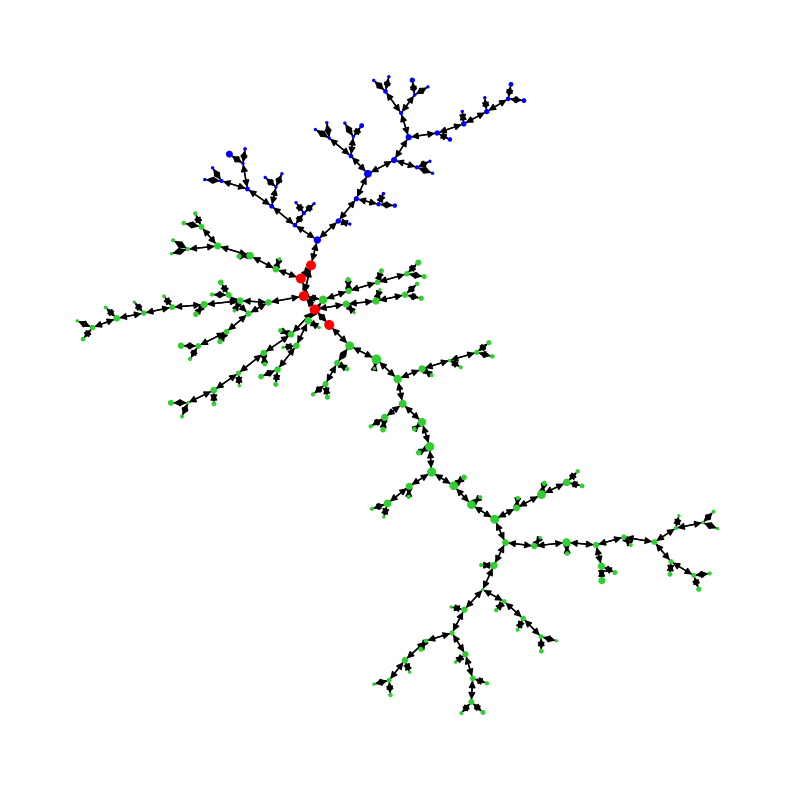

In [55]:
# calculate the target nss values, based on the mitochondrial densities, volumes, and node counts of each respective section
bio_param = calculate_target_nss(imported_neuron_graph, bio_param)
# calculate the target net influx and efflux at axon and soma terminals
bio_param = calculate_influx_efflux(imported_neuron_graph, bio_param)

# transform the graph 
G, G_subgraphs = neuron_graph_transform(imported_neuron_graph, transform_type='bidirect', n_soma_nodes=5)

# add biological parameters
G = add_bioparam_attributes(G, bio_param)


# print('\n> Edges in the transformed graph:')
#for u, v, data in G.edges(data = True): print(f'{u}-{v}: {data}')
# print('\n> Nodes in the transformed graph:')
# for node, data in G.nodes(data = True): print(f'{node}: {data}')

plot_neuron_graph_subset(G)

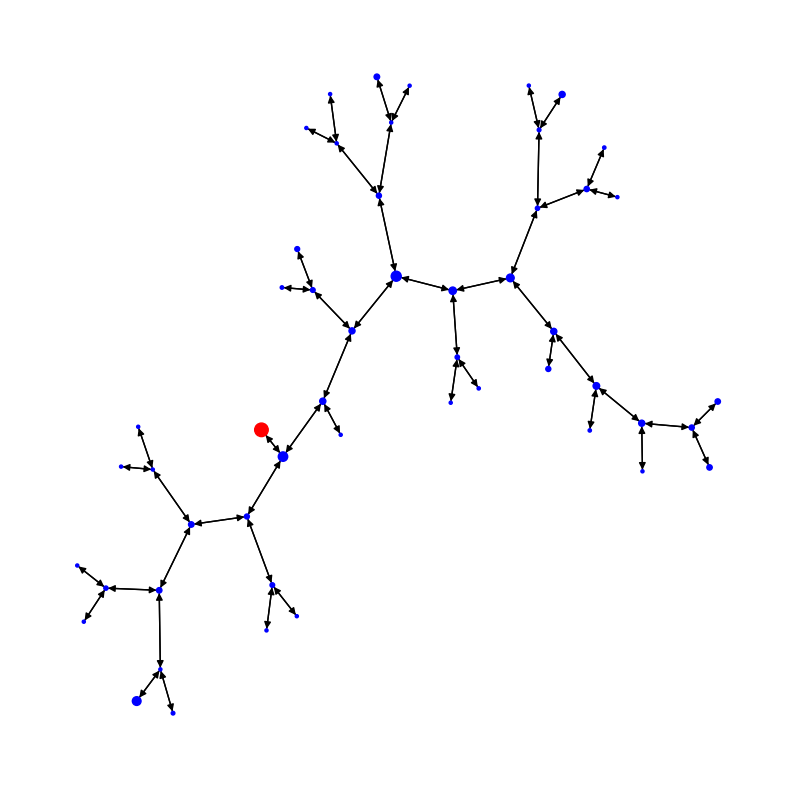

> Flux dataframe with unknowns:
          u       v direction flux_mat_i_j reverse_pair  u_popsize flux_rate    net_flux
0     A271B   A102B   reverse      (0, 44)                    25.0       0.4        10.0
1    A5255B  A4341B   reverse      (1, 29)                    25.0      r[0]   25.0*r[0]
2    A5255B  A5262B   forward       (1, 2)            4       25.0      r[1]   25.0*r[1]
3    A5255B  A5985B   forward      (1, 22)           44       25.0      r[2]   25.0*r[2]
4    A5262B  A5255B   reverse       (2, 1)                    25.0      r[3]   25.0*r[3]
..      ...     ...       ...          ...          ...        ...       ...         ...
97   A3086B  A3097B   forward      (48, 6)           14       25.0     r[48]  25.0*r[48]
98   A3086B  A3345B   forward     (48, 43)           85       25.0     r[49]  25.0*r[49]
99   A3170B  A3097B   reverse      (49, 6)                    25.0       0.4        10.0
100  A2485B  A2378B   reverse      (50, 4)                    25.0       0.4  

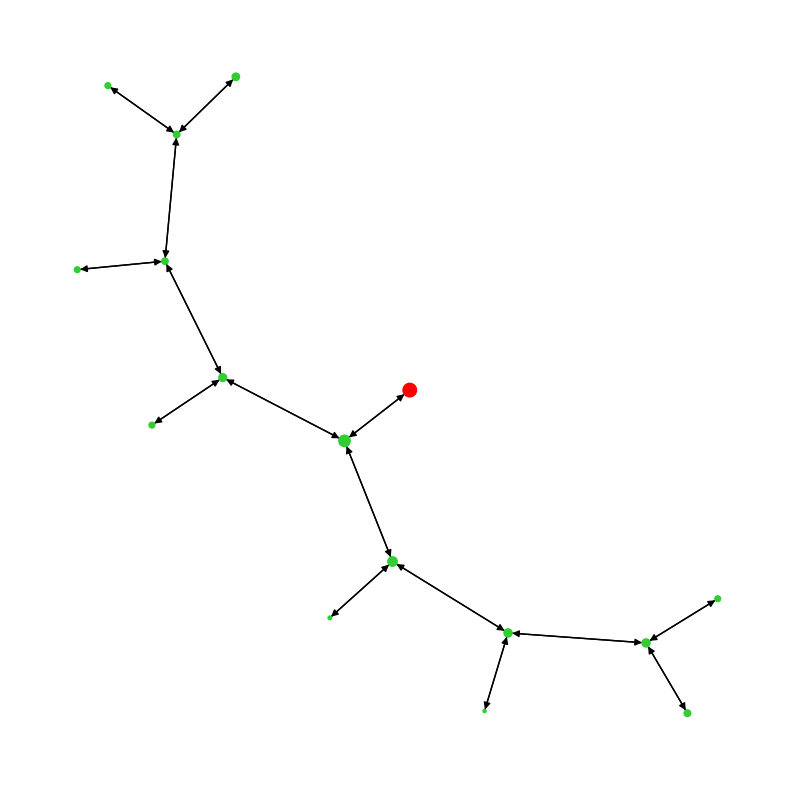

> Flux dataframe with unknowns:
         u       v direction flux_mat_i_j reverse_pair  u_popsize flux_rate     net_flux
0   D7613B  D7526B   reverse       (0, 6)                    53.0       0.4         21.2
1   D7400B  D7399B   reverse       (1, 7)                    53.0      r[0]    53.0*r[0]
2   D7400B  D7489B   forward      (1, 15)           29       53.0       0.8         42.4
3   D7400B  D7516B   forward       (1, 5)           11       53.0      r[1]    53.0*r[1]
4   D7620B  D7399B   reverse       (2, 7)                    53.0      r[2]    53.0*r[2]
5   D7620B  D7623B   forward       (2, 3)            7       53.0      r[3]    53.0*r[3]
6   D7620B  D7837B   forward      (2, 12)           26       53.0       0.8         42.4
7   D7623B  D7620B   reverse       (3, 2)                    53.0      r[4]    53.0*r[4]
8   D7623B  D7624B   forward      (3, 10)           22       53.0      r[5]    53.0*r[5]
9   D7623B  D7690B   forward       (3, 4)           10       53.0       0.8   

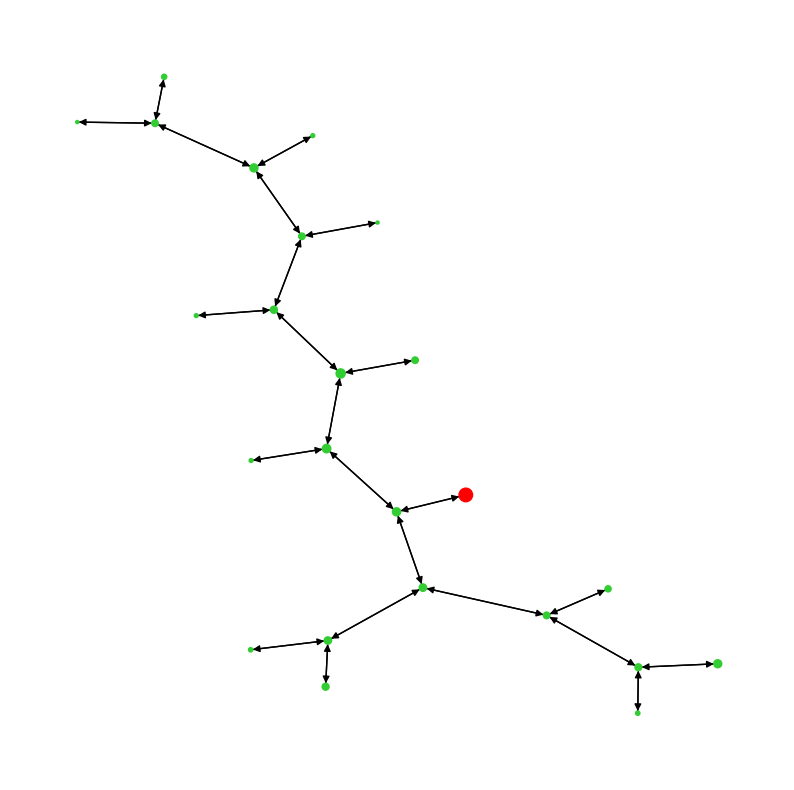

> Flux dataframe with unknowns:
         u       v direction flux_mat_i_j reverse_pair  u_popsize flux_rate    net_flux
0   D7842B  D7841B   reverse       (0, 6)                    53.0      r[0]   53.0*r[0]
1   D7842B  D7845B   forward      (0, 17)           31       53.0      r[1]   53.0*r[1]
2   D7842B  D8034B   forward      (0, 20)           38       53.0      r[2]   53.0*r[2]
3   D8193B  D8047B   reverse       (1, 3)                    53.0      r[3]   53.0*r[3]
4   D8193B  D8297B   forward      (1, 11)           23       53.0       0.8        42.4
5   D8193B  D8312B   forward      (1, 10)           20       53.0      r[4]   53.0*r[4]
6   D8185B  D8047B   reverse       (2, 3)                    53.0       0.4        21.2
7   D8047B  D7841B   reverse       (3, 6)                    53.0      r[5]   53.0*r[5]
8   D8047B  D8185B   forward       (3, 2)            6       53.0       0.8        42.4
9   D8047B  D8193B   forward       (3, 1)            3       53.0      r[6]   53.0*r[6]


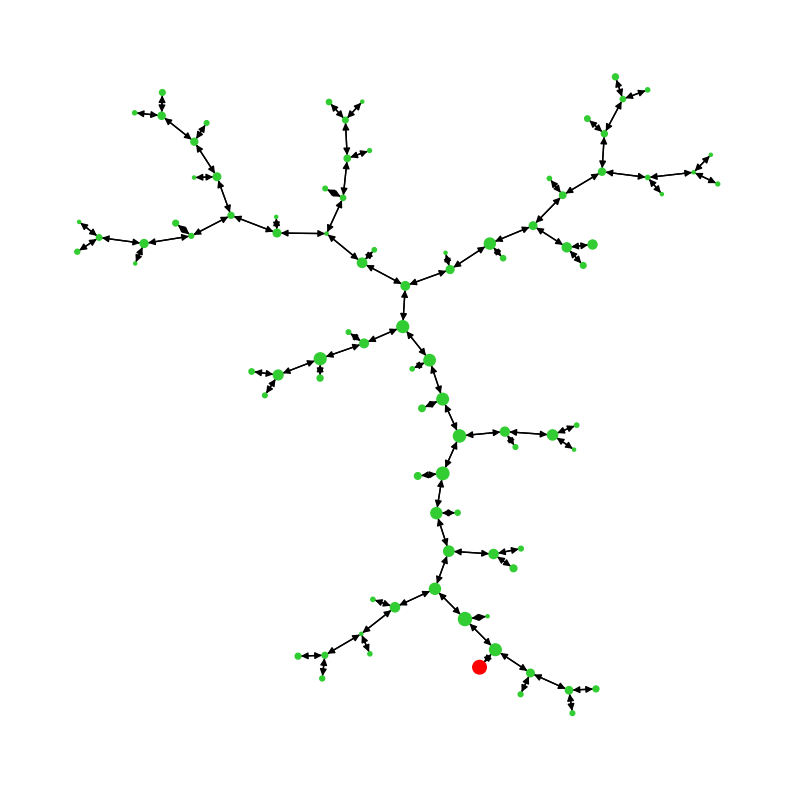

> Flux dataframe with unknowns:
          u       v direction flux_mat_i_j reverse_pair  u_popsize flux_rate    net_flux
0    D9490B  D9481B   reverse      (0, 72)                    53.0       0.4        21.2
1    D9551B  D9542B   reverse      (1, 45)                    53.0       0.4        21.2
2    D9749B  D9635B   reverse      (2, 89)                    53.0      r[0]   53.0*r[0]
3    D9749B  D9752B   forward      (2, 48)           86       53.0       0.8        42.4
4    D9749B  D9753B   forward      (2, 37)           67       53.0      r[1]   53.0*r[1]
..      ...     ...       ...          ...          ...        ...       ...         ...
177  D9635B  D9388B   reverse     (89, 84)                    53.0     r[88]  53.0*r[88]
178  D9635B  D9721B   forward     (89, 14)           24       53.0       0.8        42.4
179  D9635B  D9749B   forward      (89, 2)            2       53.0     r[89]  53.0*r[89]
180  D9557B  D9553B   reverse     (90, 85)                    53.0       0.4  

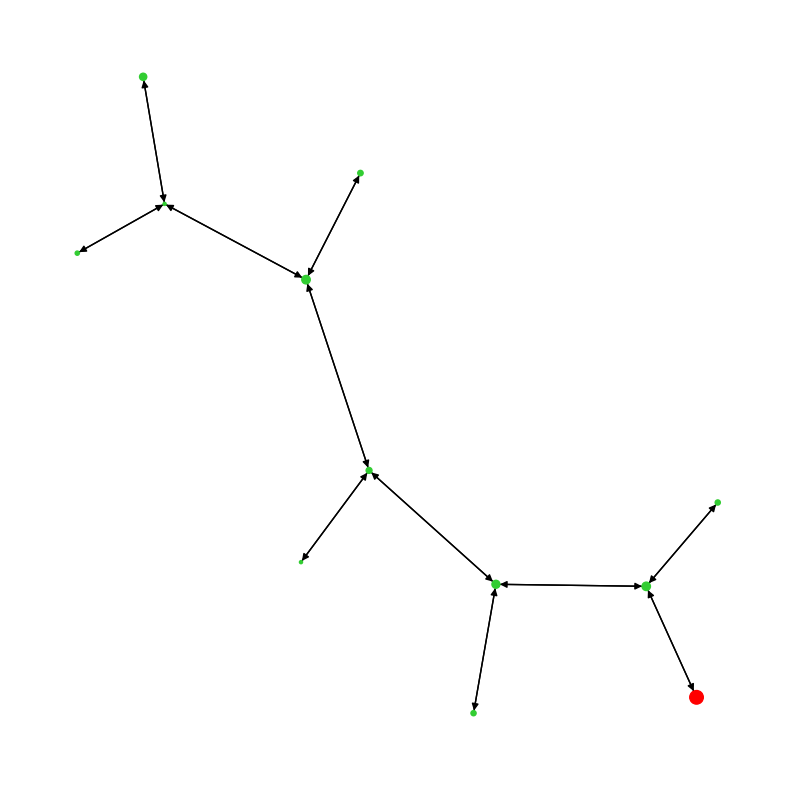

> Flux dataframe with unknowns:
          u        v direction flux_mat_i_j reverse_pair  u_popsize flux_rate    net_flux
0   D10156B  D10151B   reverse       (0, 2)                    53.0       0.4        21.2
1   D10165B  D10151B   reverse       (1, 2)                    53.0       0.4        21.2
2   D10151B  D10131B   reverse       (2, 3)                    53.0      r[0]   53.0*r[0]
3   D10151B  D10156B   forward       (2, 0)            0       53.0       0.8        42.4
4   D10151B  D10165B   forward       (2, 1)            1       53.0       0.8        42.4
5   D10131B  D10111B   reverse       (3, 4)                    53.0      r[1]   53.0*r[1]
6   D10131B  D10138B   forward       (3, 8)           16       53.0       0.8        42.4
7   D10131B  D10151B   forward       (3, 2)            2       53.0      r[2]   53.0*r[2]
8   D10111B  D10018B   reverse      (4, 10)                    53.0      r[3]   53.0*r[3]
9   D10111B  D10121B   forward       (4, 6)           14       53.0 

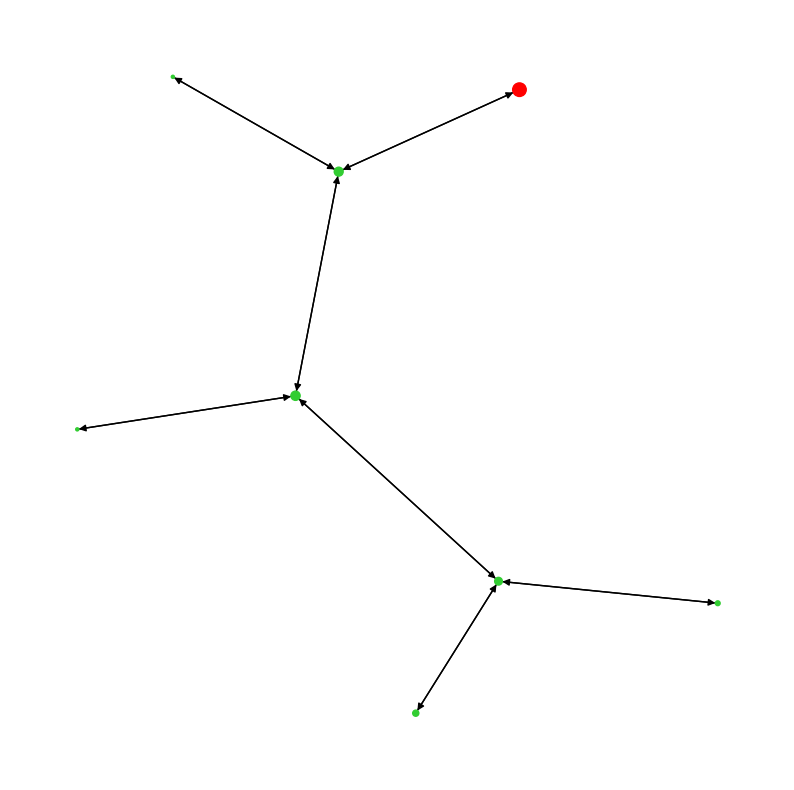

> Flux dataframe with unknowns:
          u        v direction flux_mat_i_j reverse_pair  u_popsize flux_rate    net_flux
0   D10173B  D10183B   forward       (0, 3)            7       53.0       0.8        42.4
1   D10173B  D10187B   forward       (0, 2)            4       53.0      r[0]   53.0*r[0]
2   D10173B      S3B   reverse       (0, 1)                    53.0      r[1]   53.0*r[1]
3       S3B  D10173B   forward       (1, 0)            2      520.0      r[2]  520.0*r[2]
4   D10187B  D10173B   reverse       (2, 0)                    53.0      r[3]   53.0*r[3]
5   D10187B  D10332B   forward       (2, 7)           13       53.0       0.8        42.4
6   D10187B  D10377B   forward       (2, 5)            9       53.0      r[4]   53.0*r[4]
7   D10183B  D10173B   reverse       (3, 0)                    53.0       0.4        21.2
8   D10553B  D10377B   reverse       (4, 5)                    53.0       0.4        21.2
9   D10377B  D10187B   reverse       (5, 2)                    53.0 

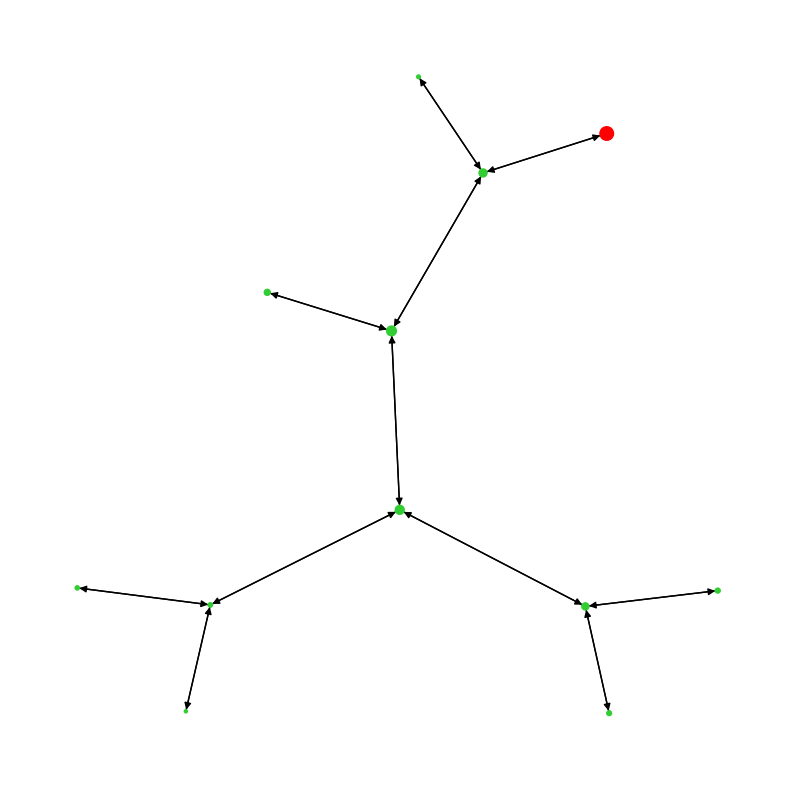

> Flux dataframe with unknowns:
          u        v direction flux_mat_i_j reverse_pair  u_popsize flux_rate    net_flux
0   D10590B  D10556B   reverse       (0, 1)                    53.0      r[0]   53.0*r[0]
1   D10590B  D10746B   forward       (0, 7)           13       53.0       0.8        42.4
2   D10590B  D10747B   forward       (0, 2)            6       53.0      r[1]   53.0*r[1]
3   D10556B  D10585B   forward      (1, 10)           20       53.0       0.8        42.4
4   D10556B  D10590B   forward       (1, 0)            0       53.0      r[2]   53.0*r[2]
5   D10556B      S4B   reverse       (1, 5)                    53.0      r[3]   53.0*r[3]
6   D10747B  D10590B   reverse       (2, 0)                    53.0      r[4]   53.0*r[4]
7   D10747B  D10767B   forward       (2, 9)           17       53.0      r[5]   53.0*r[5]
8   D10747B  D10804B   forward       (2, 8)           14       53.0      r[6]   53.0*r[6]
9   D10776B  D10767B   reverse       (3, 9)                    53.0 

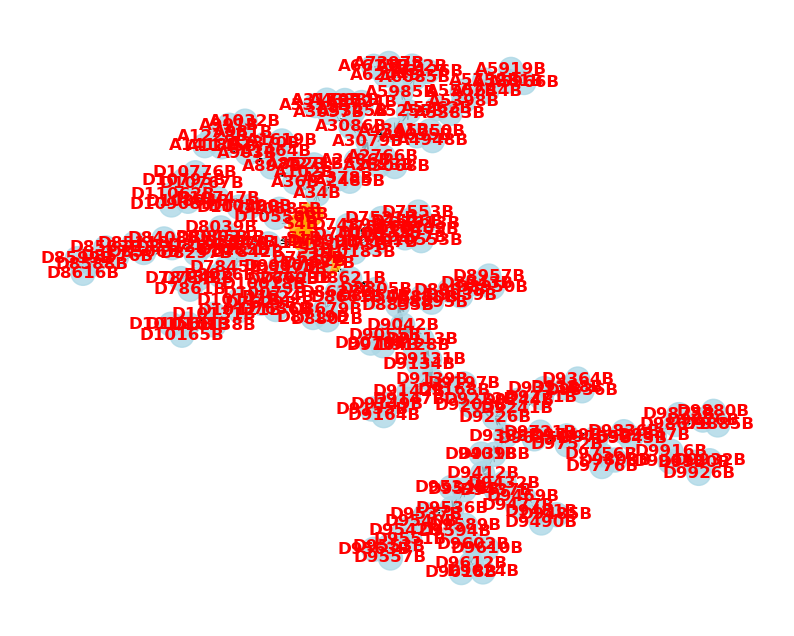

-3859.6213


In [56]:
outflow = 0
for subgraph_nodes in G_subgraphs:
    H = G.subgraph(subgraph_nodes)
    plot_neuron_graph_subset(H)
    flux_dict, net_soma_flux = solve_subgraph_flux(H)
    outflow += net_soma_flux
    nx.set_edge_attributes(G, flux_dict, 'rate')

G, bio_param = adjust_soma_birthrate(G, bio_param, outflow)
    
plot_simulator_graph(G)
print(outflow)

In [62]:
TIME_POINTS = np.linspace(0, 100, 1001)
VARS, NODES = names_from_network(G)
START_STATE = start_state_from_nodes(G, heteroplasmy=0.01)

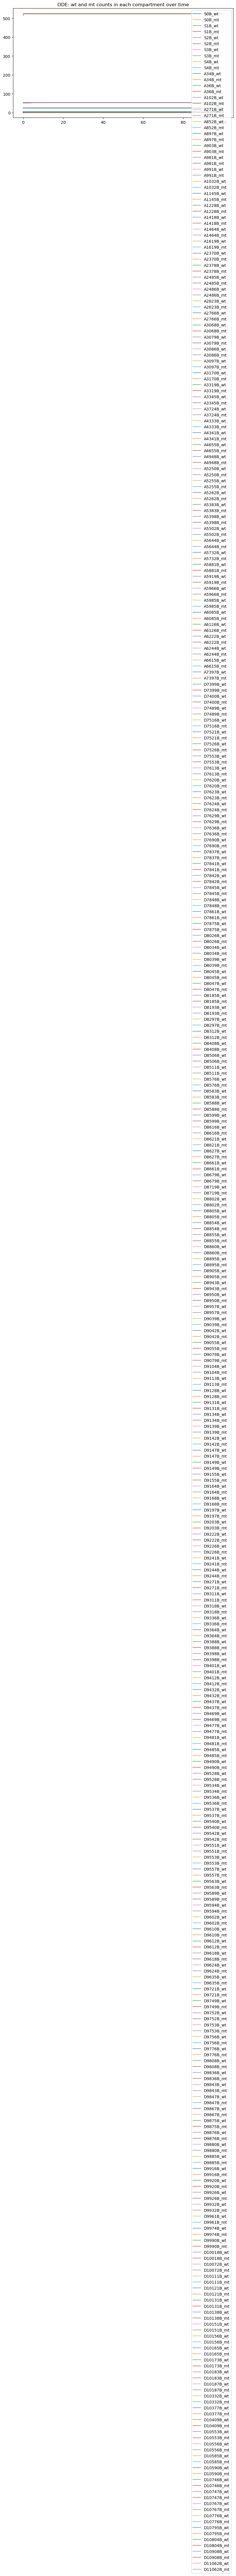

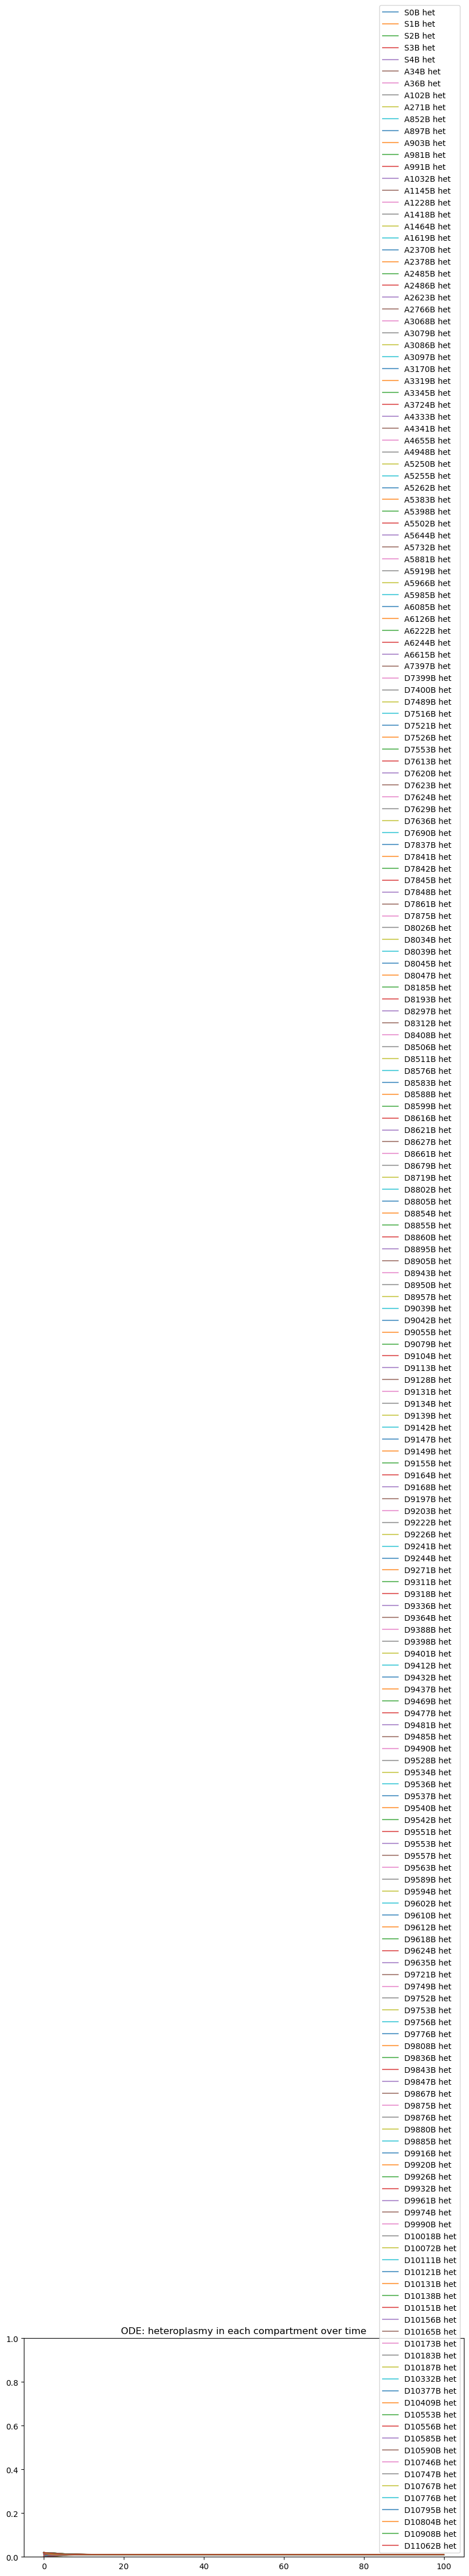

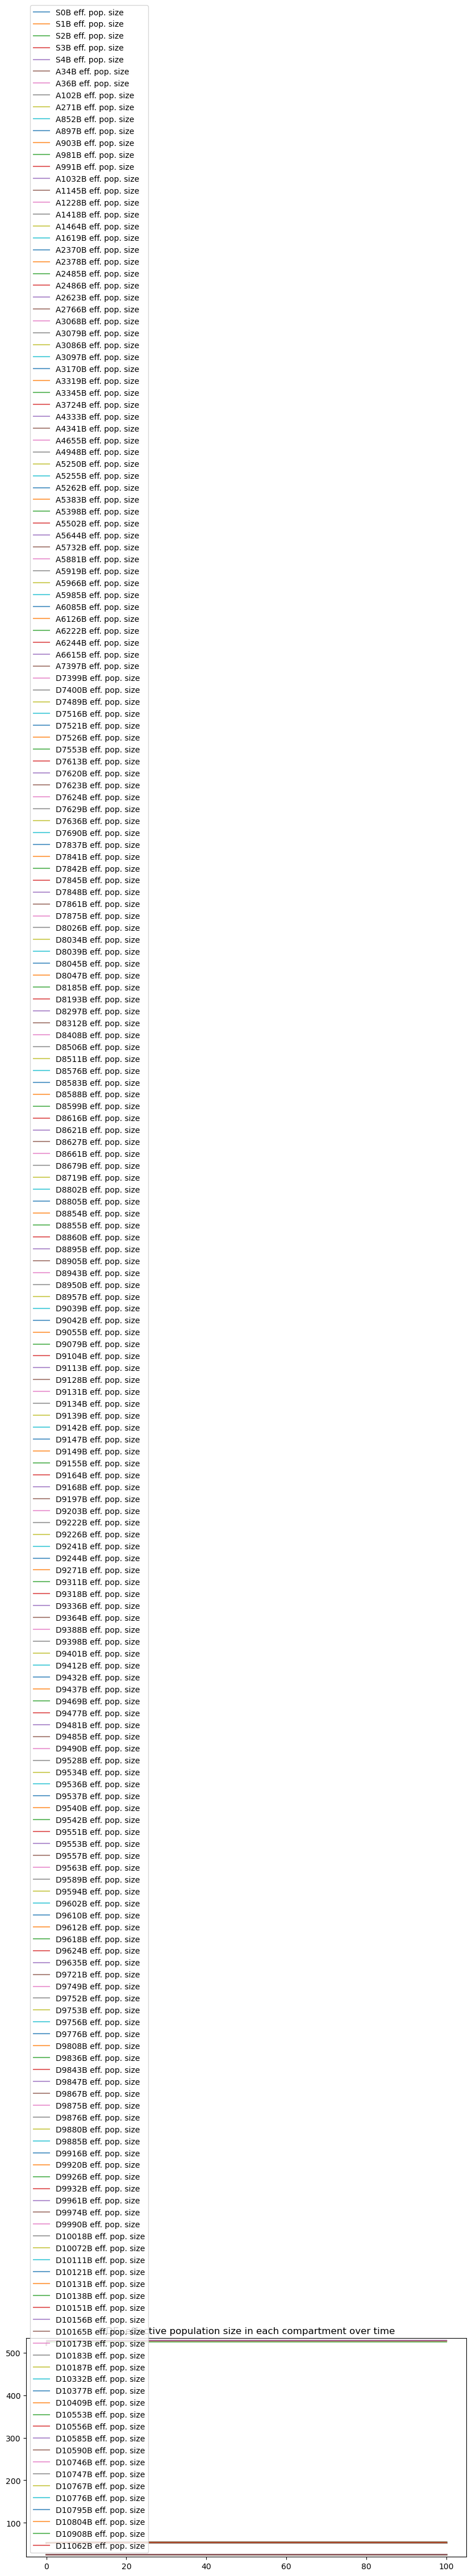

> Final counts of mt and wt in each compartment:
S0B_wt	525.2174	
S0B_mt	5.6483	
S1B_wt	524.6507	
S1B_mt	5.6422	
S2B_wt	522.5066	
S2B_mt	5.6191	
S3B_wt	525.461	
S3B_mt	5.6509	
S4B_wt	525.7462	
S4B_mt	5.654	
A34B_wt	25.2506	
A34B_mt	0.2715	
A36B_wt	25.2506	
A36B_mt	0.2715	
A102B_wt	25.2506	
A102B_mt	0.2715	
A271B_wt	25.2506	
A271B_mt	0.2715	
A852B_wt	25.2506	
A852B_mt	0.2715	
A897B_wt	25.2506	
A897B_mt	0.2715	
A903B_wt	25.2506	
A903B_mt	0.2715	
A981B_wt	25.2506	
A981B_mt	0.2715	
A991B_wt	25.2506	
A991B_mt	0.2715	
A1032B_wt	25.2506	
A1032B_mt	0.2715	
A1145B_wt	25.2506	
A1145B_mt	0.2715	
A1228B_wt	25.2506	
A1228B_mt	0.2715	
A1418B_wt	25.2506	
A1418B_mt	0.2715	
A1464B_wt	25.2506	
A1464B_mt	0.2715	
A1619B_wt	25.2506	
A1619B_mt	0.2715	
A2370B_wt	25.2506	
A2370B_mt	0.2715	
A2378B_wt	25.2506	
A2378B_mt	0.2715	
A2485B_wt	25.2506	
A2485B_mt	0.2715	
A2486B_wt	25.2506	
A2486B_mt	0.2715	
A2623B_wt	25.2506	
A2623B_mt	0.2715	
A2766B_wt	25.2506	
A2766B_mt	0.2715	
A3068B_wt	25.2506	
A3068B_mt	0.2715	
A

In [63]:
ODE_model = ODE_from_network(G, prnt=False)
plot_ODE(simulate_ode(ODE_model, TIME_POINTS, START_STATE), TIME_POINTS, DELTA, VARS, NODES)

simulating...


100%|██████████| 100/100 [12:18<00:00,  7.38s/it]


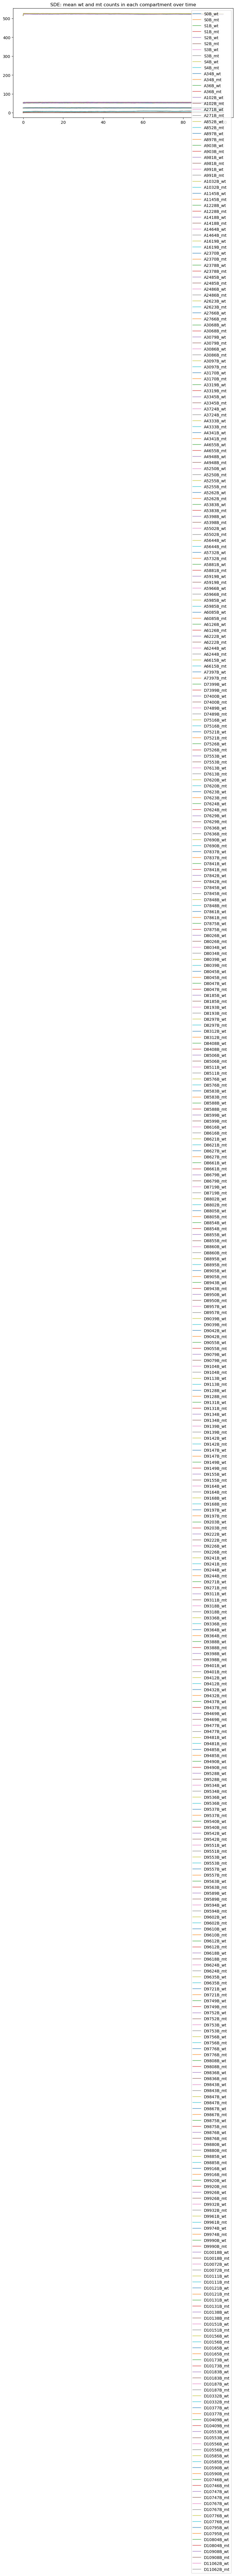

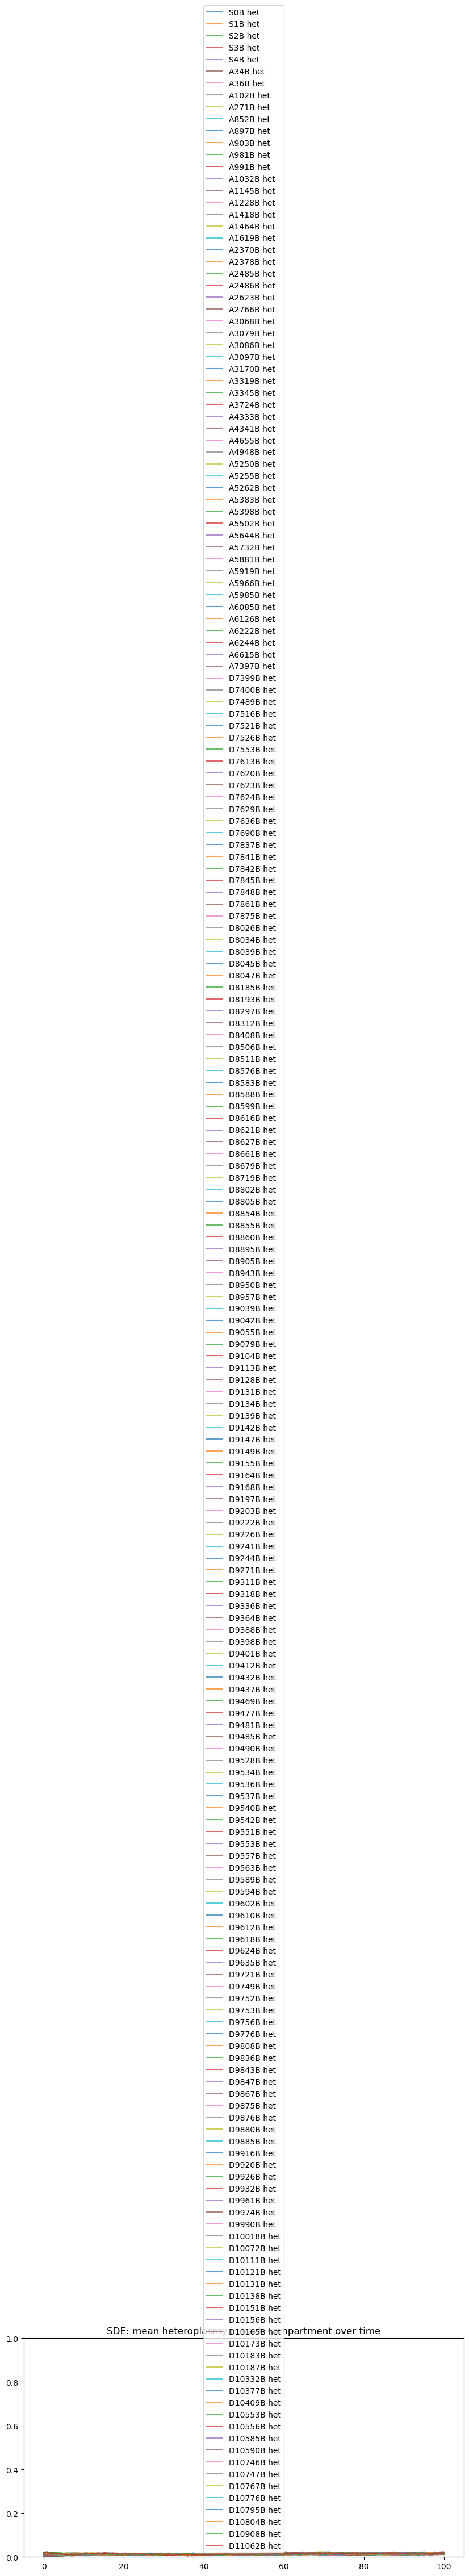

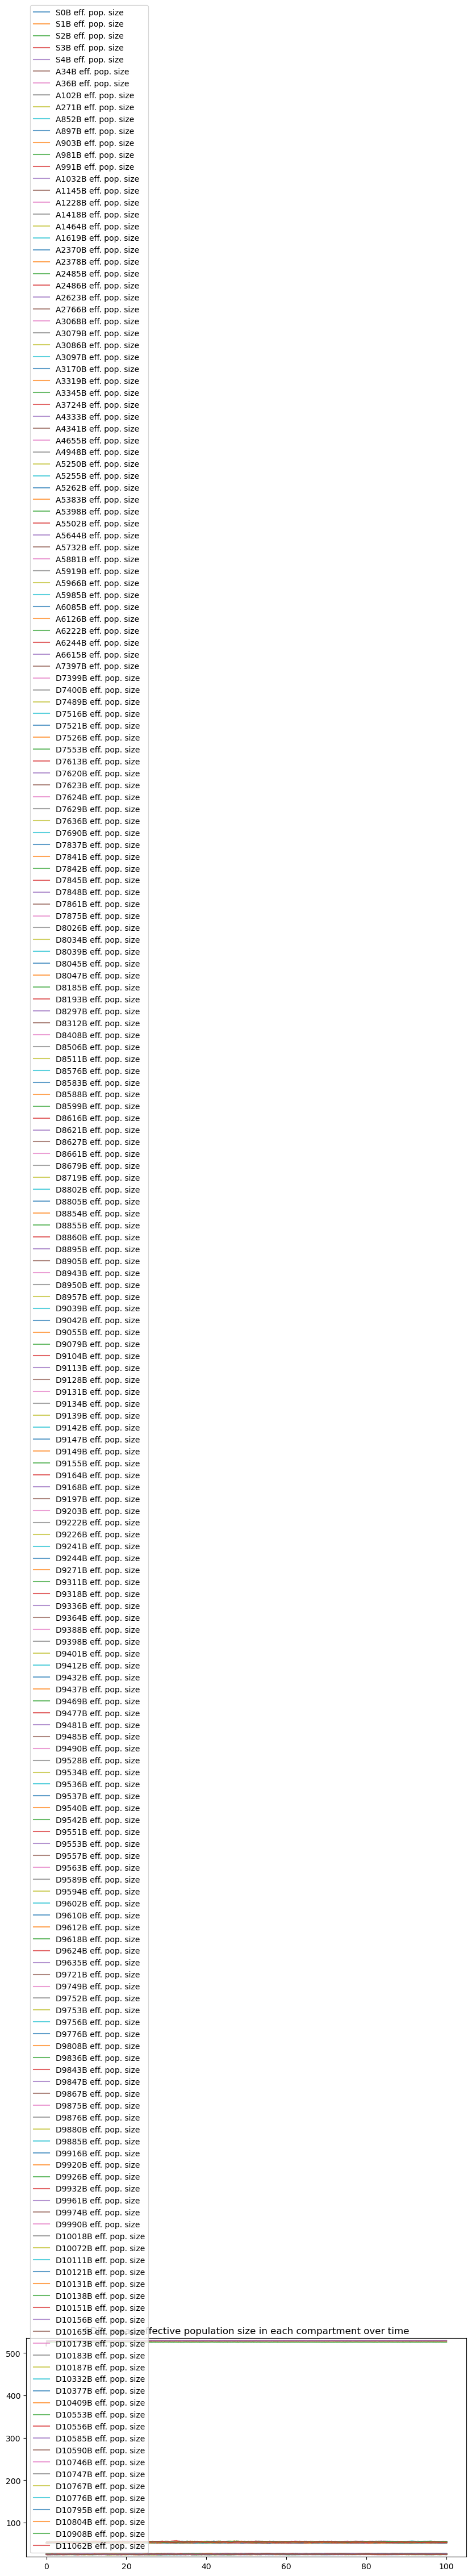

> Final mean counts of mt and wt in each compartment:
S0B_wt	523.78	
S0B_mt	9.18	
S1B_wt	522.85	
S1B_mt	10.22	
S2B_wt	520.44	
S2B_mt	10.29	
S3B_wt	524.72	
S3B_mt	8.58	
S4B_wt	525.01	
S4B_mt	9.07	
A34B_wt	25.73	
A34B_mt	0.4	
A36B_wt	24.82	
A36B_mt	0.43	
A102B_wt	25.18	
A102B_mt	0.38	
A271B_wt	25.02	
A271B_mt	0.35	
A852B_wt	25.5	
A852B_mt	0.48	
A897B_wt	25.83	
A897B_mt	0.45	
A903B_wt	25.43	
A903B_mt	0.48	
A981B_wt	25.28	
A981B_mt	0.64	
A991B_wt	25.16	
A991B_mt	0.36	
A1032B_wt	25.52	
A1032B_mt	0.32	
A1145B_wt	25.98	
A1145B_mt	0.54	
A1228B_wt	26.01	
A1228B_mt	0.5	
A1418B_wt	24.84	
A1418B_mt	0.39	
A1464B_wt	25.48	
A1464B_mt	0.49	
A1619B_wt	25.33	
A1619B_mt	0.38	
A2370B_wt	24.7	
A2370B_mt	0.36	
A2378B_wt	25.81	
A2378B_mt	0.5	
A2485B_wt	24.71	
A2485B_mt	0.47	
A2486B_wt	25.14	
A2486B_mt	0.63	
A2623B_wt	24.18	
A2623B_mt	0.42	
A2766B_wt	24.98	
A2766B_mt	0.47	
A3068B_wt	24.83	
A3068B_mt	0.51	
A3079B_wt	25.1	
A3079B_mt	0.36	
A3086B_wt	24.69	
A3086B_mt	0.55	
A3097B_wt	24.9	
A3097B_mt	0.51	
A3170B_w

In [65]:
GILL_PARAM = gillespie_param_from_network(G)
gillespie_results = simulate_gillespie(GILL_PARAM, TIME_POINTS, START_STATE, replicates=100)
plot_gillespie(gillespie_results, TIME_POINTS, DELTA, VARS, NODES)